In [32]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
from torchvision import transforms


In [4]:
test_directory = '../data/test/'
train_directory = '../data/train/'


In [5]:
directory = '../data/test/'
def load_datasets(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory,label,filename)
            image_paths.append(image_path)
            labels.append(label)
            #print(label,'loaded complete')
    return (image_paths,labels)


In [6]:
train = pd.DataFrame()
train['image'],train['label'] = load_datasets(train_directory)

In [7]:
train = train.sample(frac = 1).reset_index(drop=True)
train.head()

,image,label
0,../data/train/angry/Training_26524970.jpg,angry
1,../data/train/happy/Training_55301252.jpg,happy
2,../data/train/happy/Training_33087162.jpg,happy
3,../data/train/happy/Training_6699067.jpg,happy
4,../data/train/angry/Training_60607708.jpg,angry


In [8]:
test  = pd.DataFrame()
test['image'],test['label'] = load_datasets(test_directory)

In [9]:
test = test.sample(frac = 1).reset_index(drop = True)
test.head()

,image,label
0,../data/test/happy/PrivateTest_30557630.jpg,happy
1,../data/test/happy/PrivateTest_33232827.jpg,happy
2,../data/test/neutral/PrivateTest_73643339.jpg,neutral
3,../data/test/sad/PublicTest_18104359.jpg,sad
4,../data/test/fear/PublicTest_13590004.jpg,fear


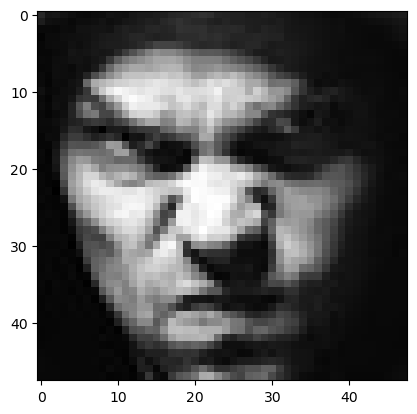

In [10]:
img = Image.open(train['image'][0])
plt.imshow(img,cmap = 'gray')

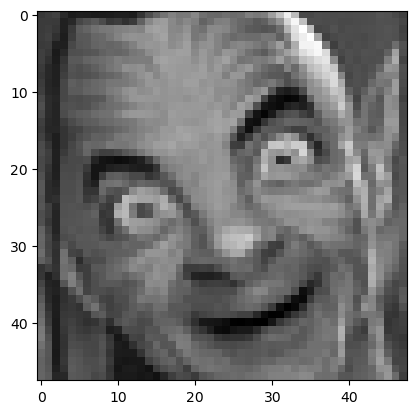

In [11]:
img = Image.open(train['image'][1])
plt.imshow(img,cmap='gray')

In [12]:
def extract_features(image_paths):
    transforms_pipeline = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((48,48)),
        transforms.ToTensor()])

    features = []
    for path in image_paths:
        img = Image.open(path).convert('RGB')
        img = transforms_pipeline(img)
        features.append(img)
    
    features = torch.stack(features)
    return features

In [13]:
train_features = extract_features(train['image'])
test_features = extract_features(test['image'])

In [14]:
x_train = train_features/255.0
x_test = test_features/255.0

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

y_train = torch.tensor(y_train,dtype = torch.long)
y_test= torch.tensor(y_test,dtype = torch.long)

print(y_train)

tensor([0, 3, 3,  ..., 5, 5, 5])


In [36]:
input_shape = (48,48,1)
output_class = 7
print(x_train.shape)


torch.Size([28709, 1, 48, 48])


In [41]:
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)  
        self.dropout = nn.Dropout(0.4)

        self.fc1 = nn.Linear(1, 512)  
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.flatten_dim = None  

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)

        if self.flatten_dim is None:
            self.flatten_dim = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_dim, 512).to(x.device)

        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

        


In [42]:
model = MyModel(num_classes=7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

train_dataset = TensorDataset(x_train,y_train)
test_dataset = TensorDataset(x_test,y_test)
train_loader = DataLoader(train_dataset,batch_size = 128,shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128,shuffle = True)

In [43]:
for epoch in range(50):
    model.train()
    for images,labels in train_loader:
        images,labels = images.to(device),labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    correct  = 0
    total = 0
    with torch.no_grad():
        for images,labels in test_loader:
            images,labels = images.to(device),labels.to(device)

            outputs = model(images)
            _,predicted = torch.max(outputs.data,1)

            total = total+labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100*correct/total
    print(f'Epoch[{epoch+1}/50],Accuracy:{accuracy:.5}')



# Why the accuracy is so small??


Epoch[1/50],Accuracy:18.807
Epoch[2/50],Accuracy:13.346
Epoch[3/50],Accuracy:13.346
Epoch[4/50],Accuracy:13.332
Epoch[5/50],Accuracy:13.346
Epoch[6/50],Accuracy:28.086
Epoch[7/50],Accuracy:18.975
Epoch[8/50],Accuracy:13.346
Epoch[9/50],Accuracy:15.84
Epoch[10/50],Accuracy:17.456
Epoch[11/50],Accuracy:17.373
Epoch[12/50],Accuracy:18.292
Epoch[13/50],Accuracy:17.345
Epoch[14/50],Accuracy:15.687
Epoch[15/50],Accuracy:17.373
Epoch[16/50],Accuracy:17.373
Epoch[17/50],Accuracy:14.433
Epoch[18/50],Accuracy:14.266
Epoch[19/50],Accuracy:17.498
Epoch[20/50],Accuracy:17.373
Epoch[21/50],Accuracy:16.509
Epoch[22/50],Accuracy:17.052
Epoch[23/50],Accuracy:14.266
Epoch[24/50],Accuracy:17.233
Epoch[25/50],Accuracy:17.233
Epoch[26/50],Accuracy:17.414
Epoch[27/50],Accuracy:14.266
Epoch[28/50],Accuracy:18.654
Epoch[29/50],Accuracy:17.595
Epoch[30/50],Accuracy:18.041
Epoch[31/50],Accuracy:17.359
Epoch[32/50],Accuracy:17.261
Epoch[33/50],Accuracy:17.777
Epoch[34/50],Accuracy:15.924
Epoch[35/50],Accuracy:17